In [1]:
import torchdata.datapipes as dp
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
import ot
import matplotlib.pyplot as plt
import timeit
import copy
from math import sqrt
import pickle

In [2]:
device = torch.device('cpu')

noise_size = 24

# Number of training epochs using classical training
num_epochs = 5

# Number of iterations of Chen training
num_Chen_iters = 0

# 'Adam' of 'RMSProp'
which_optimizer = 'Adam'

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

ngpu = 0

# To keep the criterion Lipschitz
weight_cliping_limit = 0.01

batch_size = 1024

test_batch_size = 65536

w_dim = 3

a_dim = int(w_dim*(w_dim - 1)//2)

# if 1 use GAN1, if 2 use GAN2, etc.
which_model = 1

# slope for LeakyReLU
leakyReLU_slope = 0.2

# this gives the option to rum the training process multiple times with differently initialised GANs
num_trials = 1

In [3]:
# CHEN RELATION
# Levy-area satisfies a version of the Chen relation (see Chen_relation.pdf) and is the unique distribution which satisfies this version of the relation

def chen_combine(w_a_in: torch.TensorType):
    # the batch dimension of the inputs will be quartered
    out_size = w_a_in.size(0) // 2
    assert 2 * out_size == w_a_in.size(0)
    assert w_a_in.size(1) == w_dim + a_dim

    # w_0_s is from 0 to t/2 and w_s_t is from t/2 to t
    w_0_s, w_s_t = w_a_in.chunk(2)
    result = torch.clone(w_0_s + w_s_t)
    result[:, :w_dim] = sqrt(0.5) * result[:, :w_dim]
    result[:, w_dim:(w_dim + a_dim)] = 0.5 * result[:, w_dim:(w_dim + a_dim)]

    idx = w_dim
    for k in range(w_dim - 1):
        for l in range(k + 1, w_dim):
            correction_term = 0.25 * (w_0_s[:, k] * w_s_t[:, l] - w_0_s[:, l] * w_s_t[:, k])
            result[:, idx] += correction_term
            idx += 1

    return result


# prints the 2-Wasserstein distances (in each of the Levy-area dimensions) between the input and chen_combine(chen_combine(input))
# The idea behind this is that Levy-area is the unique distribution which is close to chen_combine of itself
# Indeed this is experimentally confirmed in test.ipynb

def chen_error_2step(w_a_in: torch.TensorType):
    combined_data = chen_combine(w_a_in)
    combined_data = chen_combine(combined_data)
    return [sqrt(ot.wasserstein_1d(combined_data[:, w_dim + i], w_a_in[:, w_dim + i], p=2)) for i in range(a_dim)]


# create dataloader for samples

def row_processer(row):
    return np.array(row, dtype=np.float32)


filename = f"samples/samples_{w_dim}-dim.csv"
datapipe = dp.iter.FileOpener([filename], mode='b')
datapipe = datapipe.parse_csv(delimiter=',')
datapipe = datapipe.map(row_processer)
dataloader = DataLoader(dataset=datapipe, batch_size=batch_size, num_workers=2)



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)


# GAN 1

class Generator1(nn.Module):
    def __init__(self):
        super(Generator1, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim + noise_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, a_dim)
        )

    def forward(self, input):
        return self.main(input)


class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator1, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim + a_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)



# GAN 2

class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim + noise_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, a_dim)
        )

    def forward(self, input):
        return self.main(input)


class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim + a_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# GAN 3

class Generator3(nn.Module):
    def __init__(self):
        super(Generator3, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim + noise_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, a_dim)
        )

    def forward(self, input):
        return self.main(input)


class Discriminator3(nn.Module):
    def __init__(self):
        super(Discriminator3, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim + a_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# A fixed W increment for testing purposes
W_fixed: torch.Tensor = torch.tensor([1.0,-0.5,-1.2,-0.3,0.7,0.2,-0.9,0.1,1.7])

# function that lists which pairs of W_fixed features are used for each dimension of a_dim
def list_pairs(m):
    fixed_w_list = [1.0,-0.5,-1.2,-0.3,0.7,0.2,-0.9,0.1,1.7]
    lst =[]
    for k in range(m):
        for l in range(k+1,m):
            lst.append((fixed_w_list[k],fixed_w_list[l]))

    return lst

W_fixed = W_fixed[:w_dim].unsqueeze(1).transpose(1,0)
W_fixed = W_fixed.expand((test_batch_size,w_dim))

# Load "true" samples generated from this fixed W increment
test_filename = f"samples/fixed_samples_{w_dim}-dim.csv"
A_fixed_true = np.genfromtxt(test_filename,dtype=float,delimiter=',',)
A_fixed_true = A_fixed_true[:,w_dim:(w_dim+a_dim)]

one = torch.FloatTensor([1])
mone = one * -1


In [4]:
# a list that records trial results in the following form (lowest_errors, best_net_params)
trial_results = []
best_trial_min_sum = min_sum = float('inf')
best_trial_params = None

for trial in range(num_trials):
    # initialize nets
    if which_model == 1:
        netD = Discriminator1().to(device)
        netG = Generator1().to(device)
    if which_model == 2:
        netD = Discriminator2().to(device)
        netG = Generator2().to(device)
    elif which_model == 3:
        netD = Discriminator3().to(device)
        netG = Generator3().to(device)

    netD.apply(weights_init)
    netG.apply(weights_init)


    # Initialise optimiser

    # if which_optimizer == 'Adam':
    #     optG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.99))
    #     optD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.99))
    # elif which_optimizer == 'RMSProp':
    #     optG = torch.optim.RMSprop(netG.parameters(), lr=lr)
    #     optD = torch.optim.RMSprop(netD.parameters(), lr=lr)

    optG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.99))
    optD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.99))

    # Prepare early stopping

    min_sum = float('inf')
    min_sum_errors = [1.0 for i in range(a_dim)]
    min_sum_paramsG = copy.deepcopy(netG.state_dict())
    min_sum_paramsD = copy.deepcopy(netD.state_dict())

    # Start classical training

    iters = 0

    for epoch in range(num_epochs):

        for i, data in enumerate(dataloader):
            netD.zero_grad()

            # weight clipping so critic is lipschitz
            for p in netD.parameters():
                p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)

            # check actual batch size (last batch could be shorter)
            b_size = data.size(0)

            # Train Discriminator
            # first on real data
            out_D_real = netD(data)
            lossDr = out_D_real.mean()

            # then on fake samples
            # data has shape (b_size, w_dim + a_dim) where w_dim are the dimensions of the driving BM and a_dim is the dim of Levy Areas
            W = data[:,:w_dim]
            noise = torch.randn((b_size,noise_size), dtype=torch.float, device=device)
            gen_in = torch.cat((noise,W),1)
            # generate fake data
            generated_A = netG(gen_in)
            fake_in = torch.cat((W,generated_A.detach()),1)

            out_D_fake = netD(fake_in)
            lossDf = out_D_fake.mean()

            lossD = lossDf - lossDr
            lossD.backward()
            optD.step()

            # train Generator every 5 iterations
            if iters%10 == 0:
                netG.zero_grad()

                fake_in = torch.cat((W,generated_A),1)
                lossG = - netD(fake_in)
                lossG = lossG.mean()
                lossG.backward()
                optG.step()

            if iters%100 == 0:
                # Test Wasserstein error for fixed W
                noise = torch.randn((test_batch_size,noise_size), dtype=torch.float, device=device)
                g_in = torch.cat((noise,W_fixed),1)
                A_fixed_gen = netG(g_in).detach().numpy()
                errors = [sqrt(ot.wasserstein_1d(A_fixed_true[:,i],A_fixed_gen[:,i],p=2)) for i in range(a_dim)]

                # Print out partial results
                pretty_errors = ["{0:0.5f}".format(i) for i in errors]
                # pretty_chen_errors = ["{0:0.5f}".format(i) for i in ch_err]
                print(f"trial: {trial}/{num_trials},  epoch: {epoch}/{num_epochs}, iter: {iters},\n errors: {pretty_errors}")

                # Early stopping checkpoint
                error_sum = sum(errors)
                if error_sum <= min_sum:
                    min_sum = error_sum
                    min_sum_errors = errors
                    min_sum_paramsG = copy.deepcopy(netG.state_dict())
                    min_sum_paramsD = copy.deepcopy(netD.state_dict())
                    print("Saved parameters")

            iters += 1


    # end of trial
    # record trial results

    result = (min_sum_errors, min_sum_paramsG, min_sum_paramsD)
    trial_results.append(result)

    if min_sum < best_trial_min_sum:
        best_trial_min_sum = min_sum
        best_trial_params = (min_sum_paramsG, min_sum_paramsD)

trial: 0/1,  epoch: 0/5, iter: 0,
 errors: ['0.11235', '0.21900', '0.19593']
Saved parameters
trial: 0/1,  epoch: 0/5, iter: 100,
 errors: ['0.17007', '0.07912', '0.16047']
Saved parameters
trial: 0/1,  epoch: 0/5, iter: 200,
 errors: ['0.09119', '0.05050', '0.15665']
Saved parameters
trial: 0/1,  epoch: 0/5, iter: 300,
 errors: ['0.11658', '0.06649', '0.14959']
trial: 0/1,  epoch: 0/5, iter: 400,
 errors: ['0.09188', '0.08816', '0.14740']
trial: 0/1,  epoch: 0/5, iter: 500,
 errors: ['0.13068', '0.09942', '0.15854']
trial: 0/1,  epoch: 0/5, iter: 600,
 errors: ['0.13845', '0.11052', '0.15226']
trial: 0/1,  epoch: 0/5, iter: 700,
 errors: ['0.14787', '0.11502', '0.18959']
trial: 0/1,  epoch: 0/5, iter: 800,
 errors: ['0.15430', '0.11481', '0.16694']
trial: 0/1,  epoch: 0/5, iter: 900,
 errors: ['0.12659', '0.11334', '0.16400']
trial: 0/1,  epoch: 0/5, iter: 1000,
 errors: ['0.13571', '0.12338', '0.16405']
trial: 0/1,  epoch: 0/5, iter: 1100,
 errors: ['0.11894', '0.11814', '0.16241']
t

In [5]:
# save the parameters of the best trial
best_paramsG, best_paramsD = best_trial_params
torch.save(best_paramsG, f'model_saves/GAN{which_model}_{w_dim}d_{num_epochs}epochs_generator.pt')
torch.save(best_paramsD, f'model_saves/GAN{which_model}_{w_dim}d_{num_epochs}epochs_discriminator.pt')
file_for_results = open(f'testing_results/GAN{which_model}_{w_dim}d_{num_epochs}epochs_{which_optimizer}_{lr}lr_results.obj', 'wb+')
pickle.dump(trial_results, file_for_results)

{0: [0.09119092735059643], 1: [0.050501424543068676], 2: [0.15664823000335448]}


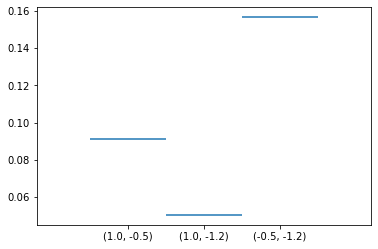

In [6]:
# Plot the results

results_per_adim = {i: [] for i in range(a_dim)}

for res in trial_results:
    errs, paramsG, paramsD = res
    for i, err in enumerate(errs):
        results_per_adim[i].append(err)

print(results_per_adim)

results_per_adim = [results_per_adim[i] for i in range(a_dim)]
def list_pairs(m):
    fixed_w_list = [1.0,-0.5,-1.2,-0.3,0.7,0.2,-0.9,0.1,1.7]
    lst =[]
    for k in range(m):
        for l in range(k+1,m):
            lst.append((fixed_w_list[k],fixed_w_list[l]))

    return lst

fig, ax = plt.subplots()

ax.eventplot(results_per_adim, orientation= 'vertical')
ax.set_xticks(range(a_dim),list_pairs(w_dim))
plt.show()